In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, InputLayer
from tensorflow.keras import optimizers
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import nasnet, resnet50, densenet
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [2]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
train_gen = train_datagen.flow_from_directory(
        'flowers/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        shuffle=True)

val_gen = val_datagen.flow_from_directory(
        'flowers/valid',
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

test_gen = test_datagen.flow_from_directory(
        'flowers/test',
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

Found 6552 images belonging to 102 classes.
Found 818 images belonging to 102 classes.
Found 819 images belonging to 102 classes.


In [4]:
batch = train_gen.next()

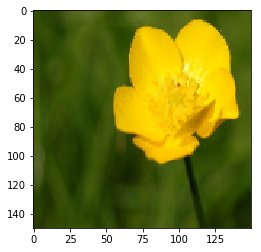

In [5]:
plt.imshow(batch[0][0])

In [6]:
batch[1][0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [7]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())         
model.add(Dense(102, activation='softmax'))

opt = optimizers.Nadam()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 82944)             0         
_________________________________________________________________
dense (Dense)                (None, 102)               8460390   
Total params: 8,479,782
Trainable params: 8,479,782
Non-trainable params: 0
______________________________________________

In [8]:
train_batches = int(train_gen.samples / train_gen.batch_size) * 2
val_batches = int(val_gen.samples / val_gen.batch_size)
train_batches, val_batches

(408, 25)

In [9]:
history = model.fit_generator(
        generator=train_gen,
        validation_data=val_gen,
        verbose=1,
        epochs=5,
        steps_per_epoch=train_batches,
        validation_steps=val_batches
)

Epoch 1/5
408/408 [==============================] - 272s 667ms/step - loss: 2.8298 - categorical_accuracy: 0.3179 - val_loss: 2.1101 - val_categorical_accuracy: 0.4750
Epoch 2/5
408/408 [==============================] - 276s 677ms/step - loss: 1.6136 - categorical_accuracy: 0.5727 - val_loss: 1.8256 - val_categorical_accuracy: 0.5550
Epoch 3/5
408/408 [==============================] - 277s 679ms/step - loss: 1.1379 - categorical_accuracy: 0.6916 - val_loss: 1.8352 - val_categorical_accuracy: 0.5838
Epoch 4/5
408/408 [==============================] - 272s 666ms/step - loss: 0.8556 - categorical_accuracy: 0.7623 - val_loss: 1.7388 - val_categorical_accuracy: 0.6175
Epoch 5/5
408/408 [==============================] - 275s 675ms/step - loss: 0.6696 - categorical_accuracy: 0.8093 - val_loss: 1.9959 - val_categorical_accuracy: 0.5813


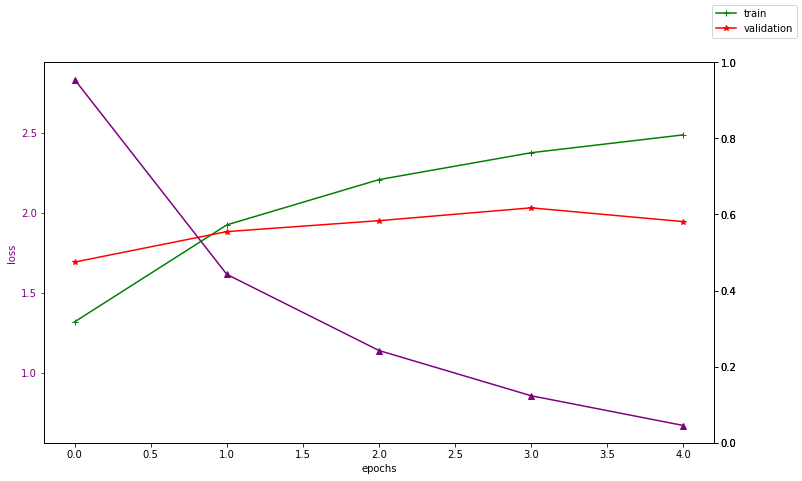

In [10]:
fig, ax1 = plt.subplots(1,1,figsize=(12,7))
ax1.plot(history.epoch, history.history['loss'], marker='^', color='purple')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss', color='purple')
ax1.tick_params('y', colors='purple')

ax2 = ax1.twinx()
plt.plot(history.epoch, history.history['categorical_accuracy'], marker='+', color='green', label='train')
ax2.set_ylim(0,1)

ax3 = ax1.twinx()
plt.plot(history.epoch, history.history['val_categorical_accuracy'], marker='*', color='red', label='validation')
ax3.set_ylim(0,1)

fig.legend();

In [11]:
model.evaluate_generator(test_gen)

[2.0268833224590006, 0.5518926]

In [17]:
test_batch = test_gen.next()

In [18]:
model.predict_classes(test_batch)

array([  0, 100,   0,  12,  98,  24,   1,   1,   2,   2,   2,   4,   2,
         2,   2,   2,  81,  41,  86,  27,   4,   4,   4,   4,   4,   4,
        15,  72,  26,  77,  51,  12])

In [20]:
test_batch[1][0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)